In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [3]:
# данные по магазинам
st_df = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/st_df.csv')

# данные по иерархии товаров
pr_df = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/pr_df.csv')

# данные по продажам
sales_df_train = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/sales_df_train.csv')

# календарь
calendar = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/holidays_covid_calendar.csv')

In [4]:
# мерджим флаг активности
sales_df_train = pd.merge(sales_df_train, st_df[['st_id','st_is_active']], on='st_id', how='left')

In [5]:
# выбираем только рабочие магазины
sales_df_train = sales_df_train[sales_df_train['st_is_active'] == 1]

In [6]:
# избавляемся от возвратных позиций
sales_df_train = sales_df_train[sales_df_train['pr_sales_in_rub'] >= 0]

In [7]:
sales_df_train.shape

(882208, 9)

In [8]:
sales_df_train_1 = sales_df_train[(sales_df_train['pr_sales_in_units'] != 0) |
                                  (sales_df_train['pr_sales_in_rub'] != 0)]

In [9]:
gr_sales_df_train_1 = sales_df_train_1.groupby(['st_id', 'pr_sku_id', 'pr_sales_type_id'])[['pr_sales_in_rub', 'pr_sales_in_units']].median().reset_index()

# Рассчитайте среднюю цену как отношение суммы продаж к общему количеству проданных товаров
gr_sales_df_train_1['median'] = gr_sales_df_train_1['pr_sales_in_rub'] / gr_sales_df_train_1['pr_sales_in_units']

gr_sales_df_train_1

,st_id,pr_sku_id,pr_sales_type_id,pr_sales_in_rub,pr_sales_in_units,median
0,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,0,146.0,1.0,146.0
1,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,1,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75,61ede1b712ff37c91101eed14b7a6c4f,1,120.0,1.0,120.0
3,084a8a9aa8cced9175bd07bc44998e75,88feeeb024d3f69da7322d76b7b53744,0,165.0,1.0,165.0
4,084a8a9aa8cced9175bd07bc44998e75,88feeeb024d3f69da7322d76b7b53744,1,120.0,1.0,120.0
...,...,...,...,...,...,...
11691,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff1f1e5d2708809c03d03ff8b689030b,1,29.0,2.0,14.5
11692,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff5cb535afe362f766ca6bd5d8e92e88,0,76.0,2.0,38.0
11693,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff5cb535afe362f766ca6bd5d8e92e88,1,22.5,0.5,45.0
11694,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,0,59.0,2.0,29.5


In [10]:
sales_df_train_1 = pd.merge(sales_df_train_1, gr_sales_df_train_1[['st_id', 'pr_sku_id', 'pr_sales_type_id', 'median']],
                            on=['st_id', 'pr_sku_id', 'pr_sales_type_id'], how='left')

In [11]:
# выводим описательную статистику
sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 0]['pr_sales_in_rub'].describe()

count    523306.000000
mean        509.415814
std        1035.687848
min           0.000000
25%         115.000000
50%         245.000000
75%         531.000000
max      169379.000000
Name: pr_sales_in_rub, dtype: float64

In [12]:
# описательная статистика продаж с промо
sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 1]['pr_sales_in_rub'].describe()

count    358449.000000
mean        726.148370
std        2129.338579
min           0.000000
25%          78.000000
50%         192.000000
75%         563.000000
max      183265.000000
Name: pr_sales_in_rub, dtype: float64

In [13]:
print('Обычные продажи в %:', round(sales_df_train_1['pr_sales_type_id'].value_counts()[0]/len(sales_df_train_1) * 100))
print('Промо продажи в %:', round(sales_df_train_1['pr_sales_type_id'].value_counts()[1]/len(sales_df_train_1) * 100))

Обычные продажи в %: 59
Промо продажи в %: 41


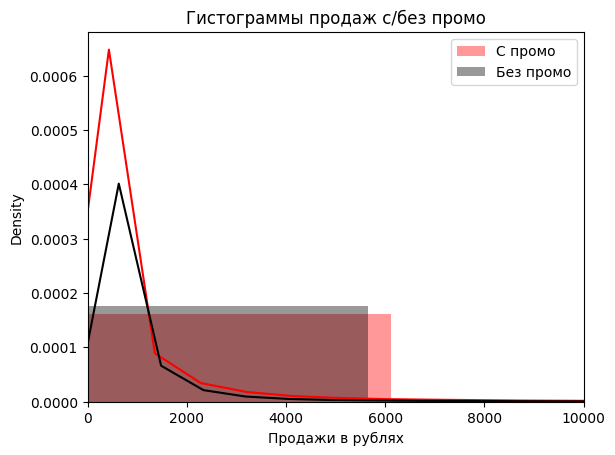

In [14]:
# гистограммы
sns.distplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 1]['pr_sales_in_rub'],
             label='С промо', color='red', bins=30)

sns.distplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 0]['pr_sales_in_rub'],
             label='Без промо', color='black', bins=30)

plt.xlabel('Продажи в рублях')
plt.title('Гистограммы продаж с/без промо')
plt.xlim(0, 10000)
plt.legend()
plt.show()

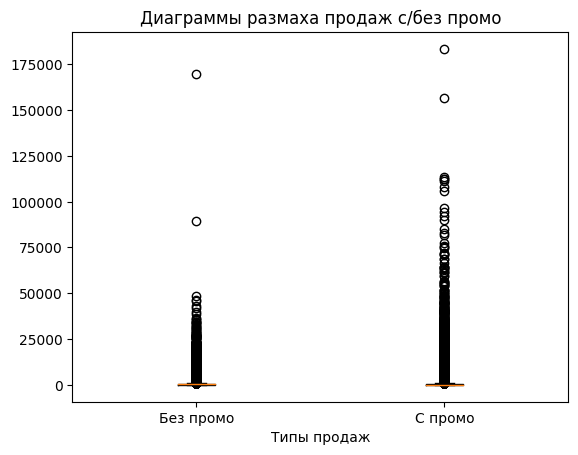

In [15]:
# диаграммы размаха
fig, ax = plt.subplots()

ax.boxplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 0]['pr_sales_in_rub'],
           positions=[1], labels=['Без промо'])

ax.boxplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 1]['pr_sales_in_rub'],
           positions=[2], labels=['С промо'])

ax.set_xlabel('Типы продаж')
ax.set_title('Диаграммы размаха продаж с/без промо')
plt.show()

In [16]:
# небольшие махинации для дальнейшего метода merge
sales_df_train_1.drop(columns='st_is_active', inplace=True)
calendar['calday'] = calendar['calday'].astype(str)
sales_df_train_1['date'] = pd.to_datetime(sales_df_train_1['date']).dt.strftime('%Y%m%d')

In [17]:
sales_df_train_1 = pd.merge(sales_df_train_1, calendar, left_on='date',
                          right_on='calday', how='left')

In [18]:
# приводим в приличный вид
sales_df_train_1.drop(columns='date_y', inplace=True)
sales_df_train_1.rename(columns={'date_x':'date'}, inplace=True)

In [19]:
# группируем данные по праздникам
holiday_comparison = sales_df_train_1.groupby('holiday').agg({'pr_sales_in_units':'sum', 'pr_sales_in_rub':'sum'}).reset_index()

In [20]:
print('На праздники приходится около {0:.2%} продаж (в шт.)'.format(holiday_comparison['pr_sales_in_units'][1] / holiday_comparison['pr_sales_in_units'].sum()))

На праздники приходится около 38.36% продаж (в шт.)


In [21]:
# добавляем фич с номером месяца
sales_df_train_1['month'] = sales_df_train_1['calday'].str[4:6]

In [22]:
# добавляем фичи с товарной иерархией
sales_df_train_1 = pd.merge(sales_df_train_1, pr_df, on='pr_sku_id', how='left')

In [23]:
# добавляем фичи с данными по магазинам
sales_df_train_1 = pd.merge(sales_df_train_1, st_df, on='st_id', how='left')

In [24]:
# продажи по месяцам
month_sales = sales_df_train_1.groupby(['year', 'month']).agg({'pr_sales_in_units':'sum'}).reset_index()

Text(0, 0.5, 'Кол-во товара')

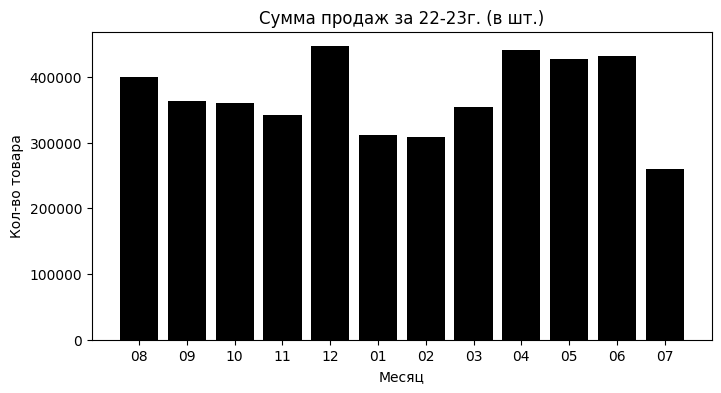

In [25]:
plt.figure(figsize=(8, 4))
plt.bar(month_sales['month'], month_sales['pr_sales_in_units'], color='black')
plt.title("Сумма продаж за 22-23г. (в шт.)")
plt.xlabel("Месяц")
plt.ylabel("Кол-во товара")

In [26]:
sales_df_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881755 entries, 0 to 881754
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    881755 non-null  object 
 1   pr_sku_id                881755 non-null  object 
 2   date                     881755 non-null  object 
 3   pr_sales_type_id         881755 non-null  int64  
 4   pr_sales_in_units        881755 non-null  float64
 5   pr_promo_sales_in_units  881755 non-null  float64
 6   pr_sales_in_rub          881755 non-null  float64
 7   pr_promo_sales_in_rub    881755 non-null  float64
 8   median                   881755 non-null  float64
 9   year                     881755 non-null  int64  
 10  day                      881755 non-null  int64  
 11  weekday                  881755 non-null  int64  
 12  calday                   881755 non-null  object 
 13  holiday                  881755 non-null  int64  
 14  covi

---